In [ ]:
pip install graphviz ipywidgets numpy pydot scikit-learn

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [ ]:
import numpy as np
from numpy.random import seed, randint
import ipywidgets as widgets
from ipywidgets import interact, interactive_output, HBox, VBox, Layout
from IPython.display import display, clear_output, SVG, HTML
import graphviz as gv # for visualizing a tree using Digraph
from graphviz import Digraph
import pydot
import random

In [ ]:
class TreeChildNode:
    def __init__(self, key):
        self.key = key
        self.parent = None

    def graphviz_handle(self):
        return "Leaf" + str(key)

    def graphviz_text(self):
        return "K" + str(key)

    def to_string(self):
        return str(self.key)

    def print_tree(self, indent):
        str("%sChildNode: %d" % (indent, self.key))

class TreeInternalNode:
    def __init__(self, key, child_refs):
        self.key = key
        self.child_refs = child_refs
        self.parent = None
        self.left = None
        self.right = None

    def to_string(self):
        return str(self.key)
    def print_tree(self, indent):
        print("%sNode: %d" % (indent, self.key))
        for i in self.child_refs:
            i[0].print_tree(indent + "  ")

n10Child = TreeChildNode(10)
n13Child = TreeChildNode(13)
n18Child = TreeChildNode(18)
n20Child = TreeChildNode(20)
n24Child = TreeChildNode(24)
n35Child = TreeChildNode(35)
n48Child = TreeChildNode(48)
n50Child = TreeChildNode(50)
n62Child = TreeChildNode(62)
n10Int = TreeInternalNode(10, [(n10Child, "DSK"), (n13Child, "MEM"), (n18Child, "MEM")])
n20Int = TreeInternalNode(20, [(n20Child, "MEM"), (n24Child, "MEM"), (n35Child, "MEM")])
n48Int = TreeInternalNode(48, [(n48Child, "MEM"), (n50Child, "MEM"), (n62Child, "MEM")])

nRoot = TreeInternalNode(0, [(n10Int, "MEM"), (n20Int, "MEM"), (n48Int, "MEM")])

# Create tree by linking the tree nodes
n10Child.parent = n10Int
n13Child.parent = n10Int
n18Child.parent = n10Int
n20Child.parent = n20Int
n24Child.parent = n20Int
n35Child.parent = n20Int
n48Child.parent = n48Int
n50Child.parent = n48Int
n62Child.parent = n48Int
n10Int.parent = nRoot
n20Int.parent = nRoot
n48Int.parent = nRoot

nRoot.print_tree("")

Node: 0
  Node: 10
  Node: 20
  Node: 48


In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from ipywidgets import interactive
# load dataset
data = load_wine()
# feature matrix
X = data.data
# target vector
y = data.target
# class labels
labels = data.feature_names
def plot_tree(crit, split, depth, min_split, min_leaf=0.2):
    estimator = DecisionTreeClassifier(random_state = 0
      , criterion = crit
      , splitter = split
      , max_depth = depth
      , min_samples_split=min_split
      , min_samples_leaf=min_leaf)
    estimator.fit(X, y)
    graph = Source(tree.export_graphviz(estimator
      , out_file=None
      , feature_names=labels
      , class_names=['0', '1', '2']
      , filled = True))

    display(SVG(graph.pipe(format='svg')))
    return estimator
inter=interactive(plot_tree
       , crit = ["gini", "entropy"]
       , split = ["best", "random"]
       , depth=[1,2,3,4]
       , min_split=(0.1,1)
       , min_leaf=(0.1,0.5))
display(inter)

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

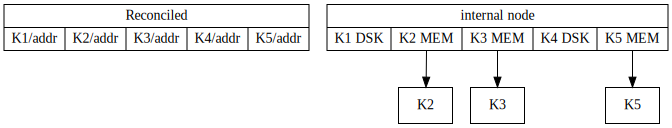

In [ ]:
import graphviz
from IPython.display import display

s = graphviz.Digraph('structs', filename='structs_revisited.gv',
                     node_attr={'shape': 'record'})

s.node('struct3', r'{Reconciled |{ K1/addr | K2/addr | K3/addr | K4/addr | K5/addr}}')
s.node('Internal1', '{internal node |{<f1> K1 DSK|<f2> K2 MEM|<f3> K3 MEM|<f4> K4 DSK|<f5> K5 MEM}}')
s.node('Leaf2', '{K2}')
s.node('Leaf3', '{K3}')
s.node('Leaf5', '{K5}')

s.edges([('Internal1:f2', 'Leaf2'), ('Internal1:f3', 'Leaf3'), ('Internal1:f5', 'Leaf5')])

display(SVG(s.pipe(format='svg')))

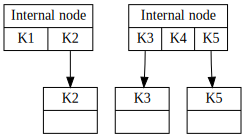

In [ ]:
import graphviz
from IPython.display import display

class TreeNode:
    def __init__(self, key, ref_state, child_refs=None):
        self.key = key
        self.child_refs = child_refs
        self.clean = True
        self.ref_state = ref_state
        self.mod_since_last_reconcile = False
        self.delta_recs = []

    def to_string(self):
        return str(self.key)

    # Review any child pages and mark the ref as modified if they were dirty.
    def reconcile(self, evict=False):
        if self.child_refs is None:
          if not self.clean:
            self.clean = True
            if evict:
              self.ref_state = "DSK"
            else:
              self.ref_state = "MEM"
            self.mod_since_last_reconcile = True
          return # Finished with a leaf page reconciliation

        delta_rec = []
        delta_rec_string = None
        for i in self.child_refs:
            if i.mod_since_last_reconcile:
              delta_rec.append("K" + i.to_string() + "/addr")
              i.mod_since_last_reconcile = False
        if delta_rec:
          delta_rec_string = "{Reconciled " + str(self.key) + " |{ " + "| ".join(delta_rec) + "}}"
          self.delta_recs.append(delta_rec_string)
          # Mark this internal page as having been reconciled, to flag reconciliation
          # of it's parent
          self.mode_since_last_reconcile = True

    def graphviz_handle(self):
        if self.child_refs is None:
            return "Leaf" + str(self.key)
        else:
            return "Internal" + str(self.key)

    def graphviz_opts(self):
        if self.clean:
            return 'color=red'
        return None

    def graphviz_edges(self):
        if self.child_refs is None:
            return None
        edges = []
        for i in self.child_refs:
            if i.ref_state != "DSK":
                start = "Internal" + str(self.key) + ":f" + str(i.key)
                if i.child_refs is None:
                    end = "Leaf" + str(i.key)
                else:
                    end = "Internal" + str(i.key)
                edges.append((start, end))
        return edges

    # TODO: Figure out how to most efficiently represent this information. There is a lot here
    # and it can easily blow out how graphs look
    def get_ref_string(self):
      ref_str = ""
      if not self.clean:
        ref_str = "MOD "

      if self.mod_since_last_reconcile:
        ref_str += "REC "

      return ref_str

    def graphviz_desc(self):
        desc_str = ""
        if self.child_refs is None:
            desc_str = "{ K" + str(self.key) + "| " + self.get_ref_string() + "}"
        else:
            desc_str = "{ Internal node | { "
            descriptors = []
            for i in self.child_refs:
                descriptors.append("<f" + str(i.key) + "> K" + str(i.key) + " " + i.get_ref_string())
            desc_str += '| '.join(descriptors)
            desc_str += "} }"
        return desc_str

    def graphviz_delta_recs(self):
      if self.delta_recs == []:
        return None
      return self.delta_recs


tn1 = TreeNode(1, "DSK")
tn2 = TreeNode(2, "MEM")
tn3 = TreeNode(3, "MEM")
tn4 = TreeNode(4, "DSK")
tn5 = TreeNode(5, "MEM")

Nodes = [tn2, tn3, tn5, TreeNode(0, "MEM", [tn1, tn2]), TreeNode(3, "MEM", [tn3, tn4, tn5])]

def GetSVG(MyNodes):
    s = graphviz.Digraph('structs', filename='structs_revisited.gv',
                         node_attr={'shape': 'record'})

    for node in MyNodes:
        fc = None
        if not node.clean:
            fc = "red"
        s.node(node.graphviz_handle(), node.graphviz_desc())
        edges = node.graphviz_edges()
        if edges is not None:
            s.edges(edges)

        reconciliations = node.graphviz_delta_recs()
        with s.subgraph(name='reconciliations') as r:
          r.node_attr['color'] = 'blue'
          r.node_attr['fillcolor'] = 'lightblue'
          r.node_attr['style'] = 'filled'
          if reconciliations is not None:
            for counter, reconciliation in enumerate(reconciliations):
              r.node('Rec' + str(node.key) + "_" + str(counter), reconciliation)

    return s.pipe(format='svg')

def DisplayGraph(MyNodes):
    display(SVG(GetSVG(MyNodes)))

DisplayGraph(Nodes)

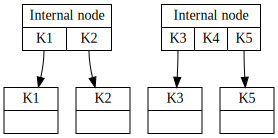

Adding in another internal node that points to a single leaf to the right of the tree


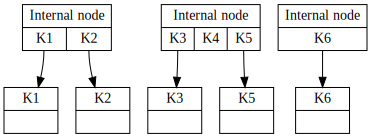

In [ ]:

tn1 = TreeNode(1, "MEM")
tn2 = TreeNode(2, "MEM")
tn3 = TreeNode(3, "MEM")
tn4 = TreeNode(4, "DSK")
tn5 = TreeNode(5, "MEM")
in0 = TreeNode(0, "MEM", [tn1, tn2])
in3 = TreeNode(3, "MEM", [tn3, tn4, tn5])

Nodes = [tn1, tn2, tn3, tn5, in0, in3]


DisplayGraph(Nodes)

print("Adding in another internal node that points to a single leaf to the right of the tree")
tn6 = TreeNode(6, "MEM")
in6 = TreeNode(6, "MEM", [tn6])

Nodes.append(tn6)
Nodes.append(in6)

DisplayGraph(Nodes)



Adding in a root page for the internal nodes


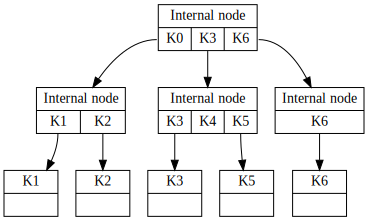

In [ ]:
print("Adding in a root page for the internal nodes")

root = TreeNode("Root", "MEM", [in0, in3, in6])
Nodes.append(root)

DisplayGraph(Nodes)

Mark page 5 as dirty


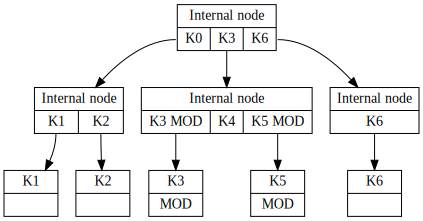

Trigger reconciliation of page 5, updating ref to mark it as modified


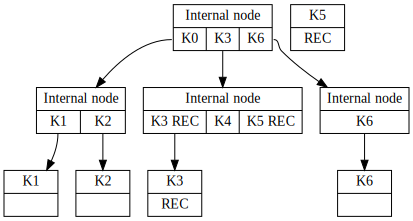

Trigger reconciliation of internal page 3, generating delta ref


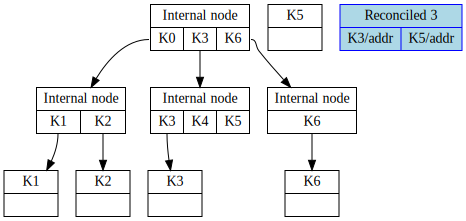

In [ ]:
print("Mark page 5 as dirty")
tn5.clean = False
tn3.clean = False
DisplayGraph(Nodes)

print("Trigger reconciliation of page 5, updating ref to mark it as modified")
# Ideally, this would probably reconcile the leaf page and propagate into internal, but that link isn't there at the moment.
tn3.reconcile()
tn5.reconcile(evict=True)

DisplayGraph(Nodes)

print("Trigger reconciliation of internal page 3, generating delta ref")
in3.reconcile()
DisplayGraph(Nodes)

In [ ]:
print("Creating and evolving a new tree")

def nodeSortFunc(e):
  return e[0]

class Tree:
  def __init__(self, mem_leaf_nodes, dsk_leaf_nodes, internal_nodes):
    self.mem_leaf_nodes = mem_leaf_nodes
    self.dsk_leaf_nodes = dsk_leaf_nodes
    self.internal_nodes = internal_nodes
    self.display_nodes = []


  def ConstructTree(self):
    leaf_node_tuples = []
    for nd in self.mem_leaf_nodes:
      leaf_node_tuples.append((nd, "MEM"))
    for nd in self.dsk_leaf_nodes:
      leaf_node_tuples.append((nd, "DSK"))

    leaf_node_tuples.sort(key=nodeSortFunc)

    leaf_nodes = []
    for nd in leaf_node_tuples:
      leaf_nodes.append(TreeNode(nd[0], nd[1]))

    inodes = []
    for count, nd in enumerate(self.internal_nodes):
      if count + 1 < len(self.internal_nodes):
        first_next_key = self.internal_nodes[count + 1]
      else:
        first_next_key = leaf_node_tuples[len(leaf_nodes) - 1][0] + 1 # Make it bigger than the biggest key.

      children = []
      for index, child_node in enumerate(leaf_node_tuples):
        if child_node[0] < nd:
          continue
        if child_node[0] >= first_next_key:
          break
        children.append(leaf_nodes[index])
      inodes.append(TreeNode(nd, "MEM", children))

    root = TreeNode("root", "MEM", inodes)

    display_nodes = []
    for leaf in leaf_nodes:
      if leaf.ref_state != "DSK":
        display_nodes.append(leaf)
    for internal in inodes:
      display_nodes.append(internal)
    display_nodes.append(root)
    self.display_nodes = display_nodes

  def DirtyLeafPage(self, pageid):
    for node in self.display_nodes:
      if node.child_refs is None and node.key == pageid:
        node.clean = False

  def Reconcile(self, pageid):
    for node in self.display_nodes:
      if node.child_refs is None and node.key == pageid:
        node.reconcile(evict=True)
        # This should probably be optional depending on whether it's an eviction
        self.display_nodes.remove(node)
        break

  def Checkpoint(self):
    # First reconcile any dirty children
    for node in self.display_nodes:
      if node.child_refs is None and not node.clean:
        node.reconcile(evict=False)
    # Reconcile all internal nodes
    for node in self.display_nodes:
      if node.child_refs is not None:
        node.reconcile(evict=False)




Creating and evolving a new tree


Construct a moderately complex tree, note that internal node contents are auto-generated


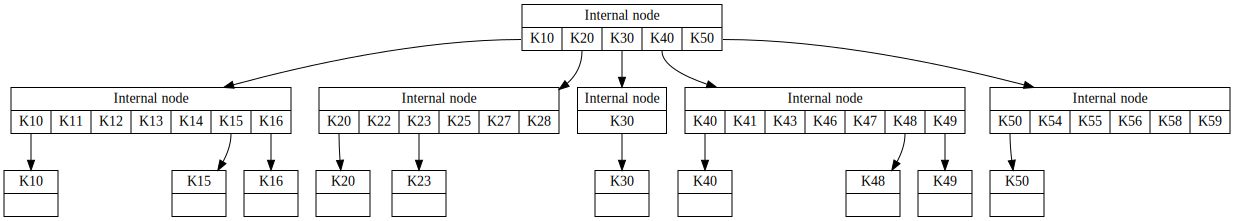

In [ ]:
mem_leaf_nodes = [10, 15, 16, 20, 23, 30, 40, 48, 49, 50]
dsk_leaf_nodes = [11, 12, 13, 14, 22, 25, 27, 28, 41, 43, 46, 47, 54, 55, 56, 58, 59]
internal_nodes = [10, 20, 30, 40, 50]

tree = Tree(mem_leaf_nodes, dsk_leaf_nodes, internal_nodes)
tree.ConstructTree()

print("Construct a moderately complex tree, note that internal node contents are auto-generated")
DisplayGraph(tree.display_nodes)



In [ ]:

print("Mark a selection of pages dirty, and trigger eviction on some of those dirty pages")
tree.DirtyLeafPage(15)
tree.DirtyLeafPage(48)
tree.DirtyLeafPage(49)

tree.Reconcile(15)
tree.Reconcile(48)

DisplayGraph(tree.display_nodes)

Mark a selection of pages dirty, and trigger eviction on some of those dirty pages


AttributeError: module 'sklearn.tree' has no attribute 'DirtyLeafPage'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Dirty another page and then trigger a checkpoint


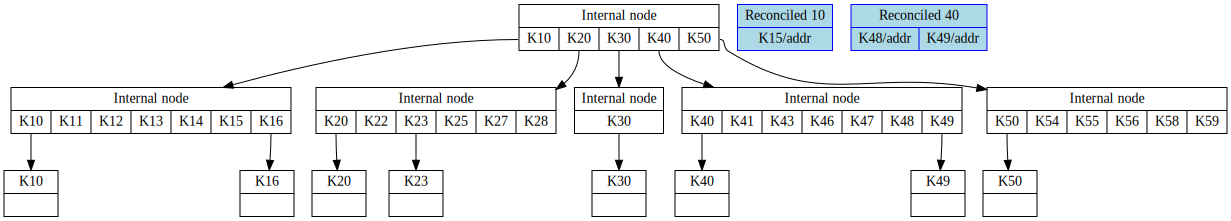

In [ ]:

print("Dirty another page and then trigger a checkpoint")
tree.Checkpoint()
DisplayGraph(tree.display_nodes)